In [2]:
import numpy as np
import scipy as sp
import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
import os
from matplotlib import pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
write_folder = os.path.join('/mnt','BigDisk','2P_scratch')


mouse = 'mCherry6'

file_list = stx.ymaze_sess_deets.CTRL_sessions[mouse]
for f in file_list[5:]:
    print(f)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
({'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 6}, {'date': '20_10_2021', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7})
{'date': '21_10_2021', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 8}
({'date': '22_10_2021', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 9}, {'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 10})


In [6]:
def check_and_make_h5s(file_list, runh5=True):
    h5list, framerates = [], []
    for f in file_list:
        print(f)
        scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
        source_folder  = os.path.join('/mnt','BigDisk','2P_scratch')
        source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
        info = tpu.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
        
        file_stem = os.path.join(write_folder,mouse,f['date'],f['scene'],scan_str)
        h5path = os.path.join(file_stem,scan_str+".h5")
        if not os.path.exists(h5path) and runh5:
            _ =  tpu.scanner_tools.sbx_utils.sbx2h5(source_stem,output_name=h5path,force_2chan=False)

        h5list.append(file_stem)
        framerates.append(info['frame_rate'])
    print(h5list)
    return h5list, framerates

In [8]:
def run_session(fdict):
    _h5list,_frs = check_and_make_h5s([fdict,],runh5=True)
    ops_dir = os.path.join(_h5list[0],'suite2p','plane0','ops.npy')
    s2p_dir = os.path.join(_h5list[0],'suite2p','plane0')

    ops = tpu.s2p.set_ops(d={'data_path': _h5list,
                                   'save_path0': _h5list[0],
                                    'fast_disk':[],
                                    'move_bin':True,
                                    'two_step_registration':True,
                                    'maxregshiftNR':10,
                                    'tau':.7,
                                    'functional_chan':1,
                                    'fs':_frs[0],
                                    'roidetect':True,
                                    'input_format':"h5",
                                    'h5py_key':'data',
                                    'nchannels':2,
                                    'threshold_scaling':1,
                                    'chan2_thresh':.01})
    ops=s2p.run_s2p(ops=ops)
    !rm {_h5list[0]}/*.h5 


for f in file_list[6:]: #file_list:
    
    if isinstance(f,tuple):
        for _f in f:
            run_session(_f)
    else:
        run_session(f)

{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 6}
0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 7286
['/mnt/BigDisk/2P_scratch/mCherry6/20_10_2021/YMaze_LNovel/YMaze_LNovel_001_001']
{}
h5
** Found 1 h5 files - converting to binary **
NOTE: using a list of h5 files:
['/mnt/BigDisk/2P_scratch/mCherry6/20_10_2021/YMaze_LNovel/YMaze_LNovel_001_001/YMaze_LNovel_001_001.h5']
time 286.17 sec. Wrote 7286 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 7286 frames
Reference frame, 22.37 sec.
Registered 2000/7286 in 92.42s
Registered 4000/7286 in 166.77s
Registered 6000/7286 in 240.16s
Registered second channel in 91.42 sec.
----------- Total 405.02 sec
Registration metrics, 15.59 sec.
NOTE: applying default /home/mplitt/.suite2p/clas

In [8]:
def update_sess_dict(mouse, f):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])

            
    source_folder = "/home/mplitt/2P_scratch"
    source_stem = os.path.join(source_folder, mouse, f['date'], f['scene'], scan_str)

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("/home/mplitt/VR_scratch",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
             })
    return f

def run_and_save(fdict,comb_frames=0):
#     with open(os.path.join('/home/mplitt/YMazeSessPkls',mouse,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),'rb') as file:
#         sess = dill.load(file)
#     sess.novel_arm = fdict['novel']    
            
    sess = stx.session.YMazeSession(**fdict)
    sess.load_scan_info()
    sess.align_VR_to_2P()
    sess.load_suite2p_data(which_ts=('F', 'Fneu','spks'), frames = slice(comb_frames,comb_frames+sess.scan_info['max_idx']))
    sess.get_trial_info()
    sess.neuropil_corrected_dff()
    
    
    sess.place_cells_calc(nperms=1000)
    
    sess.add_pos_binned_trial_matrix('F_dff')
    sess.add_timeseries(F_dff_norm = sess.timeseries['F_dff']/np.nanpercentile(sess.timeseries['F_dff'],99,axis=1,keepdims=True))
    sess.rm_pos_binned_trial_matrix('F_dff_norm')
    sess.add_pos_binned_trial_matrix('F_dff_norm')
    
    sess.add_pos_binned_trial_matrix('spks') #,speed=sess.vr_data['dz']._values, speed_thr = .05)  
    sess.add_timeseries(spks_norm = sess.timeseries['spks']/np.nanpercentile(sess.timeseries['spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('spks_norm') 

    sess.add_timeseries(licks=sess.vr_data['lick']._values)
    sess.add_pos_binned_trial_matrix('licks')
    sess.add_timeseries(speed=sess.vr_data['dz']._values)
    sess.add_pos_binned_trial_matrix('speed')
    
    tpu.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')
    return comb_frames+sess.scan_info['max_idx']

In [20]:
for f in file_list[5:6]: #file_list:
    f_ = update_sess_dict(mouse,f)
    _ = run_and_save(f_)

Fixing teleports
(141799,) (30048,)
1937.6294710327454 1937.5395465994961


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:233: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:239: UserWarning: One more trial start than teleport, assuming the final teleport got chopped
  warnings.warn(('One more trial start than teleport, assuming the final teleport got chopped'))


/home/mplitt/2P_scratch/mCherry6/19_10_2021/YMaze_LNovel/YMaze_LNovel_001_005/suite2p
173 4191
5123 9087
10021 13576
14509 17677
18611 22128
23071 30047
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900


TypeError: tuple indices must be integers or slices, not str

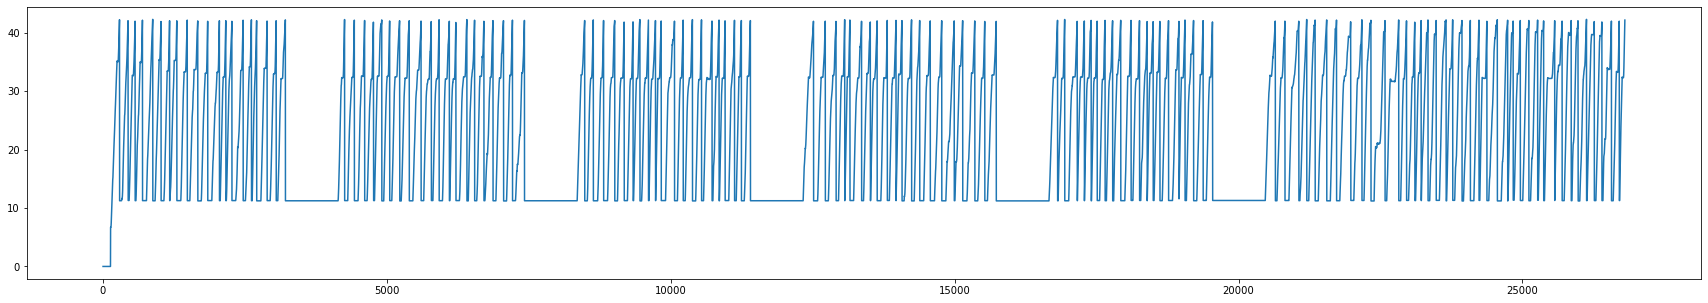

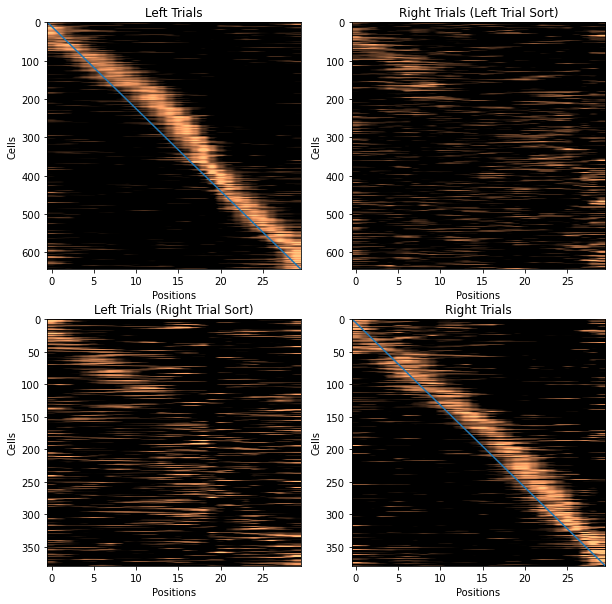

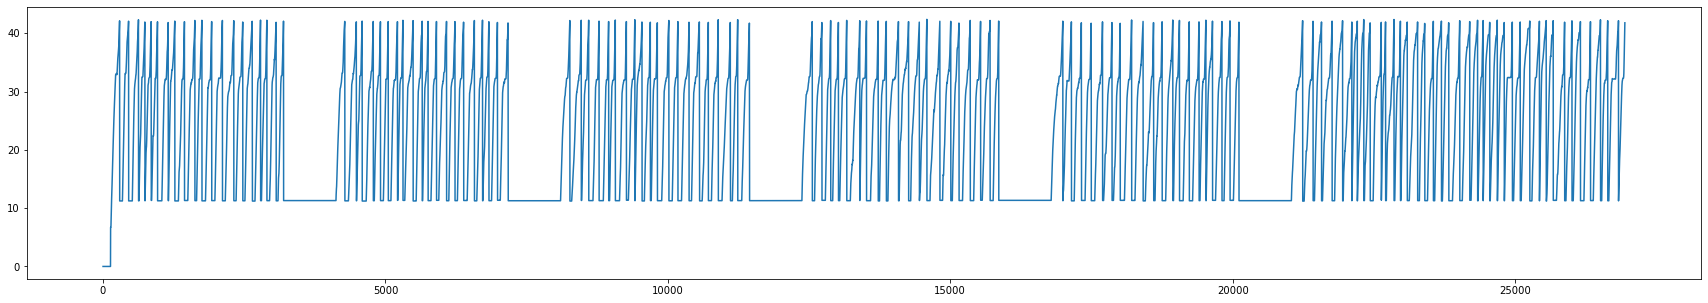

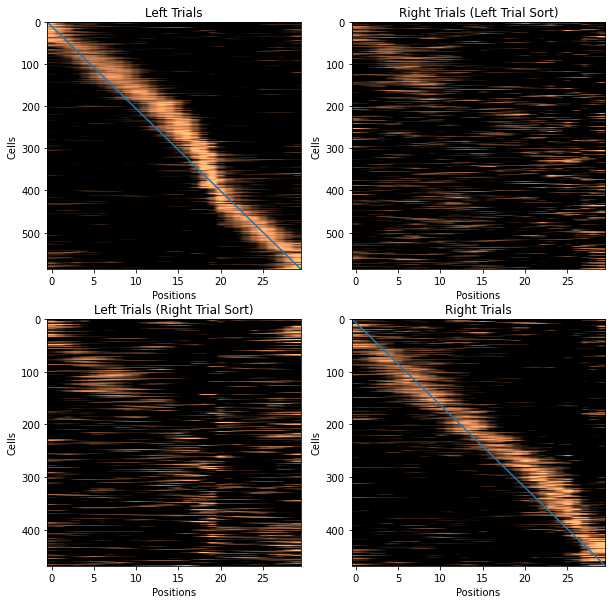

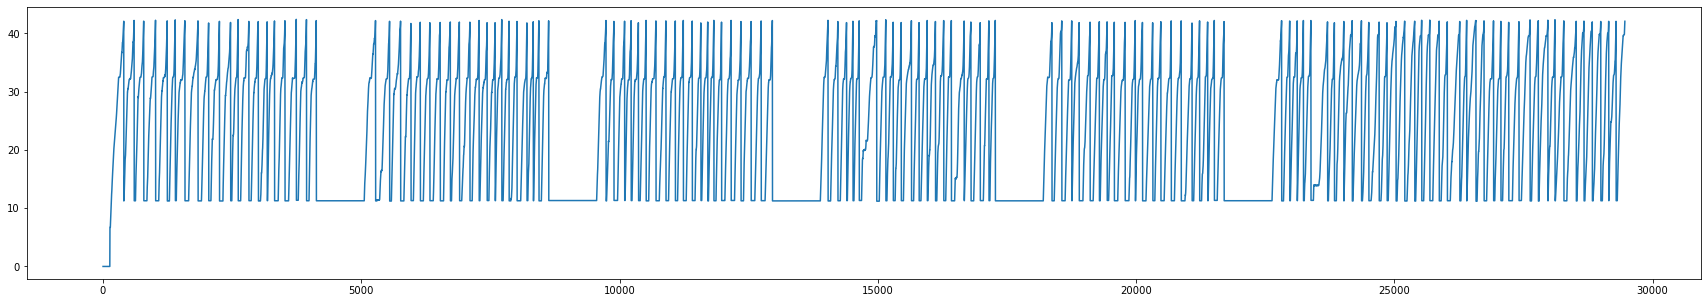

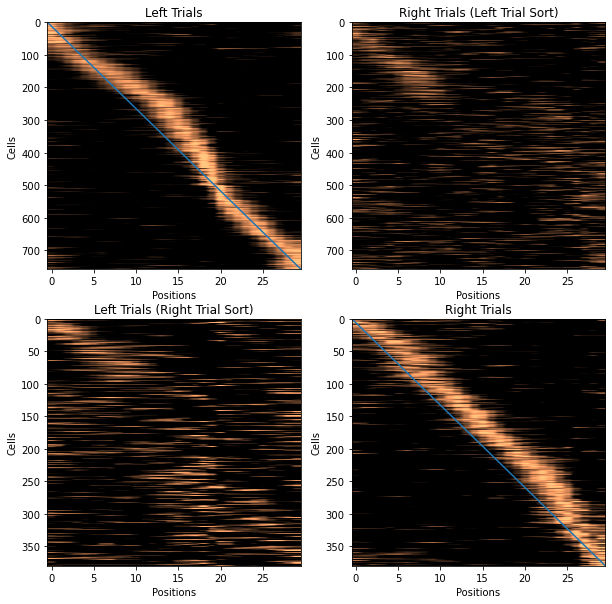

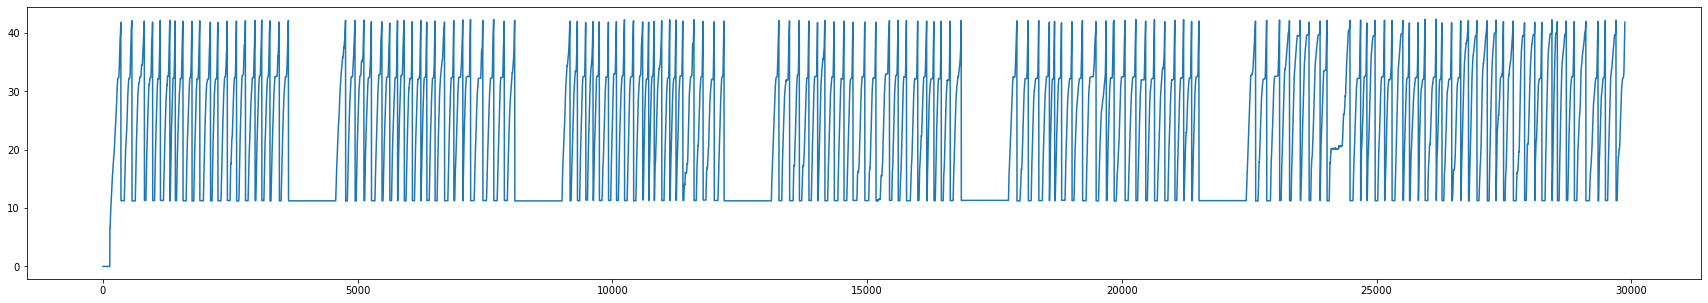

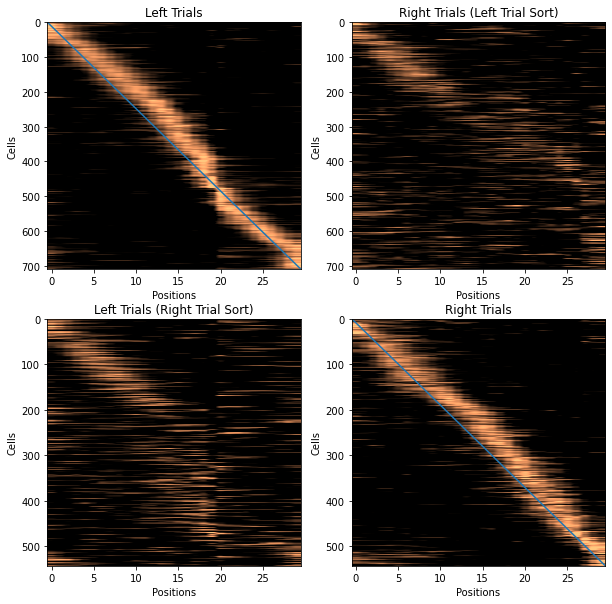

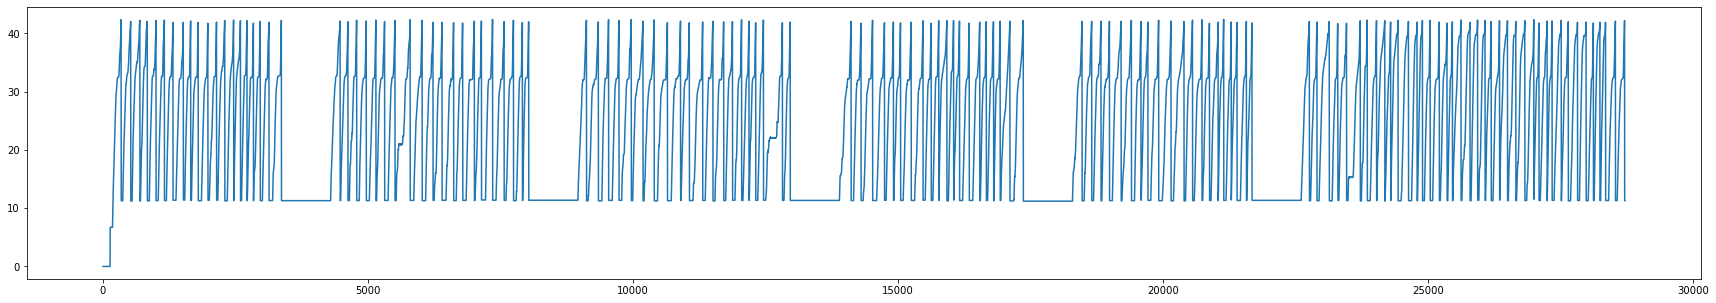

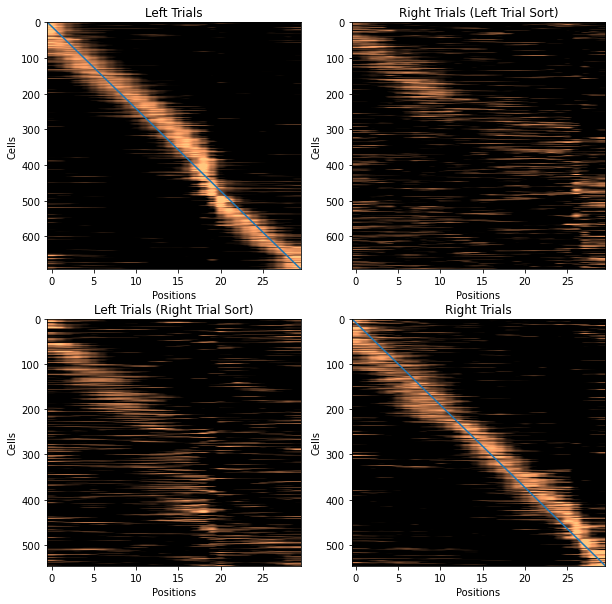

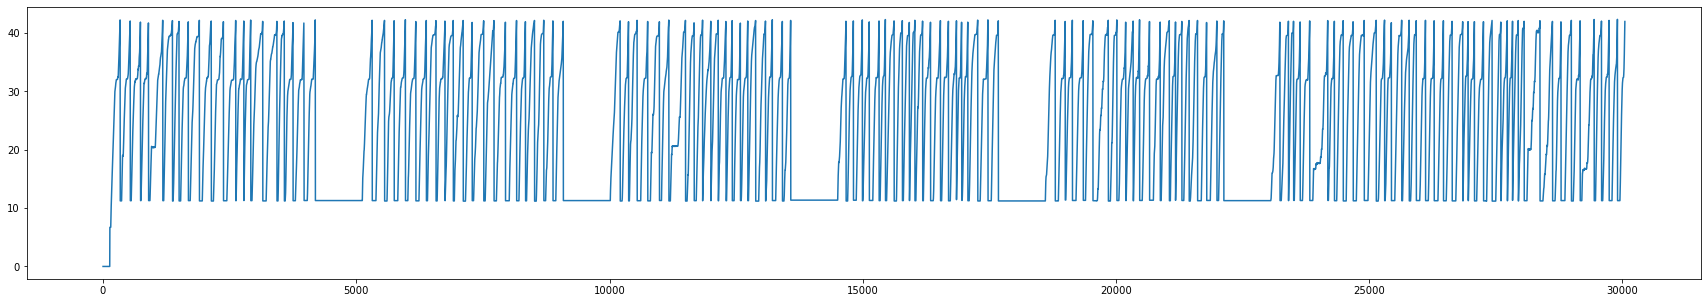

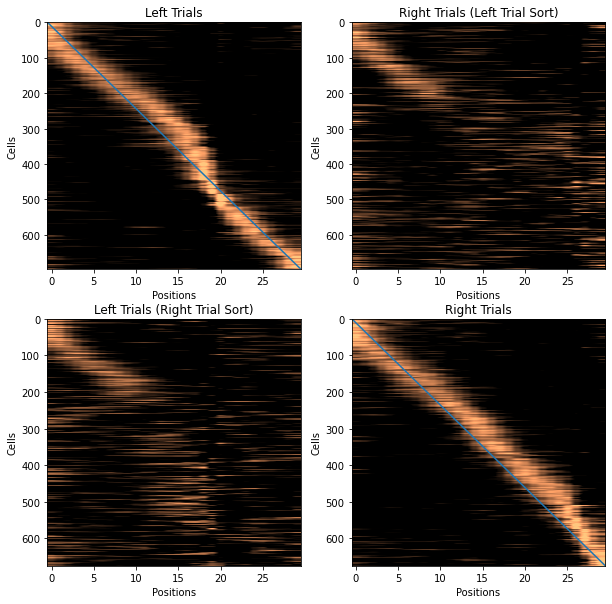

In [23]:
for f in file_list:
    sess = stx.session.YMazeSession.from_file(os.path.join("/home/mplitt/YMazeSessPkls", mouse, f['date'], "%s_%d.pkl" % (f['scene'], f['session'])))
    fig, ax = plt.subplots(figsize = [30,5])
    ax.plot(sess.vr_data['t'])
    
    
    left_pcs = sess.place_cell_info['left']['masks']
    right_pcs = sess.place_cell_info['right']['masks']
    
        # plt the place cells
    fig, ax = plt.subplots(2,2, figsize=[10,10])

    # left trials
    trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==-1,:,:][:,:,left_pcs]
    # sort by odd trials
    sort_vec = np.argsort(np.argmax(np.nanmean(trial_mat[::2,:,:],axis=0), axis=0))
    ax[0,0].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
    ax[0,0].plot([-0.5,trial_mat.shape[1]-.5], [-.5,trial_mat.shape[2]-.5])
    ax[0,0].set_ylabel('Cells')
    ax[0,0].set_xlabel('Positions')
    ax[0,0].set_title('Left Trials')
    # right trials (left sort)
    trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==1,:,:][:,:,left_pcs]
    ax[0,1].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
    ax[0,1].set_ylabel('Cells')
    ax[0,1].set_xlabel('Positions')
    ax[0,1].set_title('Right Trials (Left Trial Sort)')


    #right 
    trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==1,:,:][:,:,right_pcs]
    # sort by odd trials
    sort_vec = np.argsort(np.argmax(np.nanmean(trial_mat[::2,:,:],axis=0), axis=0))
    ax[1,1].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
    ax[1,1].plot([-0.5,trial_mat.shape[1]-.5], [-.5,trial_mat.shape[2]-.5])
    ax[1,1].set_ylabel('Cells')
    ax[1,1].set_xlabel('Positions')
    ax[1,1].set_title('Right Trials')


    # left trials (right sort)
    trial_mat = sess.trial_matrices['spks'][sess.trial_info['LR']==-1,:,:][:,:,right_pcs]
    ax[1,0].imshow(sp.stats.zscore(np.nanmean(trial_mat[1::2,:,:],axis=0),axis=0)[:,sort_vec].T, aspect='auto', cmap='copper', vmin=0, vmax=3)
    ax[1,0].set_ylabel('Cells')
    ax[1,0].set_xlabel('Positions')
    ax[1,0].set_title('Left Trials (Right Trial Sort)')